# Parametros

In [1]:
from tdgl.visualization.animate import create_animation
from IPython.display import HTML, display
from IPython.display import clear_output
from tdgl.geometry import box, circle
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import h5py
import tdgl
import time
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
#Video and animations requirements
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)
length_units = "um"

def default_solution(device,file_name,type_of_solution,vector_potential=None,terminal_currents_applied=None):
    '''
    Esta función se usa para implementar las opciones y el solver de tdgl para los posibles casos existentes.
    device: tdgl.device object
    type_of_solution: String
    vector_potential: Double
    terminal_currents: unidimensional array [source_current,drain_current]
    Depending on the type_of_solution a solution is implemented
    '''
    solution = None
    options = tdgl.SolverOptions(
    skip_time=100,  # Tiempo de relajación inicial (no se guarda información)
    solve_time=150,  # Tiempo de simulación real
    output_file=os.path.join(tempdir.name, file_name),  # Ruta del archivo de salida
    field_units="mT",  # Unidades del campo aplicado (miliTesla)
    current_units="uA",  # Unidades de la corriente (microamperios)
    save_every=100,  # Intervalo de tiempo entre guardados
    )
    if type_of_solution == "0_field_0_current" or type_of_solution == "0_current_0_field":
        solution = tdgl.solve(
        device,
        options
        )
    elif type_of_solution == "0_current": 
        solution = tdgl.solve(
        device,
        options,
        applied_vector_potential=vector_potential
        )   
    elif type_of_solution == "0_field":
         solution = tdgl.solve(
         device,
         options,
         terminal_currents= dict(source=terminal_currents_applied[0],drain=terminal_currents_applied[1]) 
        )
    else :
        solution = tdgl.solve(
         device,
         options,
         terminal_currents= dict(source=terminal_currents_applied[0],drain=terminal_currents_applied[1]),
         applied_vector_potential=vector_potential
        )
    return solution
  
    

In [2]:
# ====================================================
# CONFIGURACIÓN INICIAL
# ====================================================
H5_DIR = "./project_field_h5_files"
os.makedirs(H5_DIR, exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# Configuración de gráficas
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 2.0


In [3]:

# ====================================================
## 1. ⚙️ PARÁMETROS GLOBALES (Optimizados)
# ====================================================

### 1.1. Parámetros del Material
LENGTH_UNITS = "um"
xi = 0.5           
london_lambda = 2  
d = 0.1               
gamma = 10             


###Rectangulo grande
width_x = 24 
height_y = width_x/2     
  # Ancho del puente (dimensión x)
 # Alto del puente (dimensión y)
contact_size = width_x
STRIPE_LENGTH = 0.01   # Lado de los contactos cuadrados
OVERLAP = 0.5         # Espacio adicional para solapamiento
###Rectangulo pequeño
width_x2 = width_x/2
height_y2 = height_y-2

### 1.3. Parámetros de Malla
MAX_EDGE_LENGTH_IV = xi / 2
MAX_EDGE_LENGTH_VORTEX = xi / 2
SMOOTHING_STEPS = 100                # Reducido de 100
# Geometría inicial y capa
film_poly = tdgl.Polygon("film_base", points=box(width=width_x, height=height_y))
film_poly_down = tdgl.Polygon("film_pequeño", points=box(width=width_x2, height=height_y2)).translate(dx=-width_x/2)
half_geometry = film_poly.union(film_poly,film_poly_down)
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=gamma)

# Creación del device y de la malla

  Malla creada: 22078 puntos


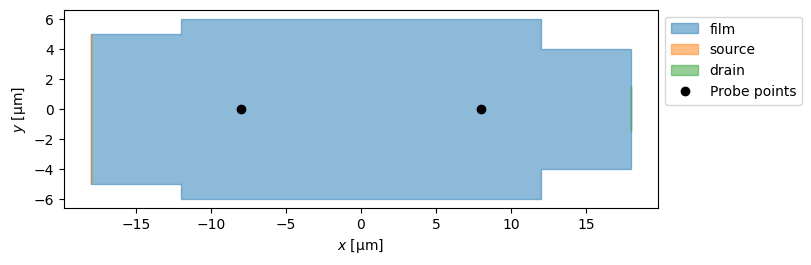

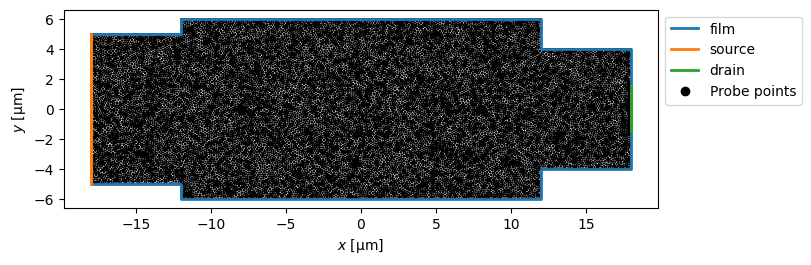

In [4]:
def create_device(geometry_used,max_edge_length,polyx=width_x2,polyy= height_y2-2,source_dimensions=[STRIPE_LENGTH,height_y2],drain_dimensions=[STRIPE_LENGTH,(height_y/4)],translationx=((width_x + width_x2 + STRIPE_LENGTH) / 2),translationy=0):
    '''
    Since we're using the same geometry, this function is implemented so we can change the position of the source and drain to our liking
    geometry_used: tdgl.polygon object,
    max_edge_length:int,
    source_dimension: array [width,height]
    drain_dimension: array [width,height]
    translationx:float
    translationy:float
    The translations move the source and drain along the polygon
    '''
    #for points that are the same as the  film width
    contact_size = width_x #1 µm squares
    # Contacto superior (source)
    film_poly_up = tdgl.Polygon("film_pequeño", points=box(width=polyx, height=polyy)).translate(dx=+width_x/2)
    combined_geometry = film_poly.union(geometry_used,film_poly_up)
    source_poly = tdgl.Polygon(
        "source", 
        points=box(width=source_dimensions[0],height=source_dimensions[1])
    ).translate(dx=-translationx).translate(dy=translationy)
    # Contacto inferior (drain)
    drain_poly = tdgl.Polygon(
        "drain", 
        points=box(width=drain_dimensions[0], height=drain_dimensions[1])
    ).translate(dx=+translationx).translate(dy=+translationy)
    # Unir geometrías
    combined_film = tdgl.Polygon.from_union([combined_geometry, source_poly, drain_poly], name="film")
    # Sondas de voltaje en el centro del puente
    probe_points = [(width_x / 3,0), (-width_x / 3,0)]
    device = tdgl.Device(
        "vertical_bridge",
        layer=layer,
        film=combined_film,
        holes=[],
        terminals=[source_poly, drain_poly],
        probe_points=probe_points,
        length_units=LENGTH_UNITS,
    )
    
    device.make_mesh(max_edge_length=max_edge_length, smooth=SMOOTHING_STEPS)
    #Remove to se more details about the mesh 
    #There are 4 malformed cells as of now , 4/5030 
    clear_output(wait=True)
    print(f"  Malla creada: {len(device.mesh.sites)} puntos")
    return device
device_fast = create_device(half_geometry,MAX_EDGE_LENGTH_IV)
fig, ax = device_fast.draw()
fig, ax = device_fast.plot(mesh=True)

# Desarrollo 

## 1)Aplicación de un campo zero para una corriente fija

In [13]:
zero_field_solution = default_solution(device_fast,"zero_field_zero_current.h5","0_field",terminal_currents_applied=[28,-28])

Simulating: 100%|█████████████████████▉| 150/150 [07:25<00:00,  2.97s/tau ]


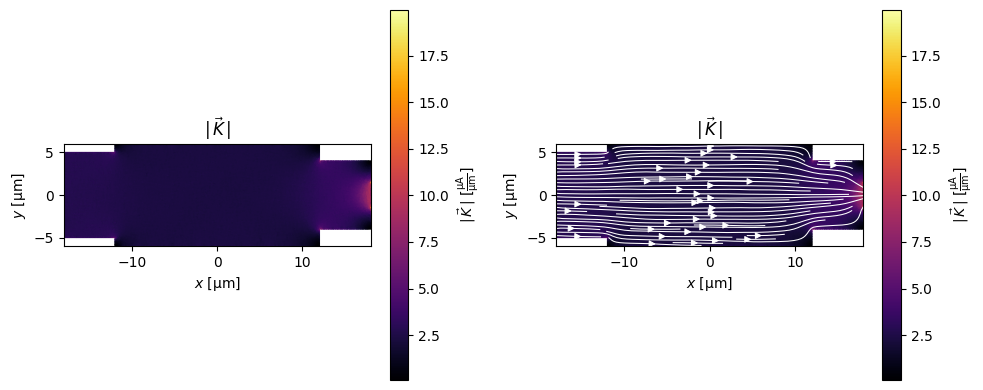

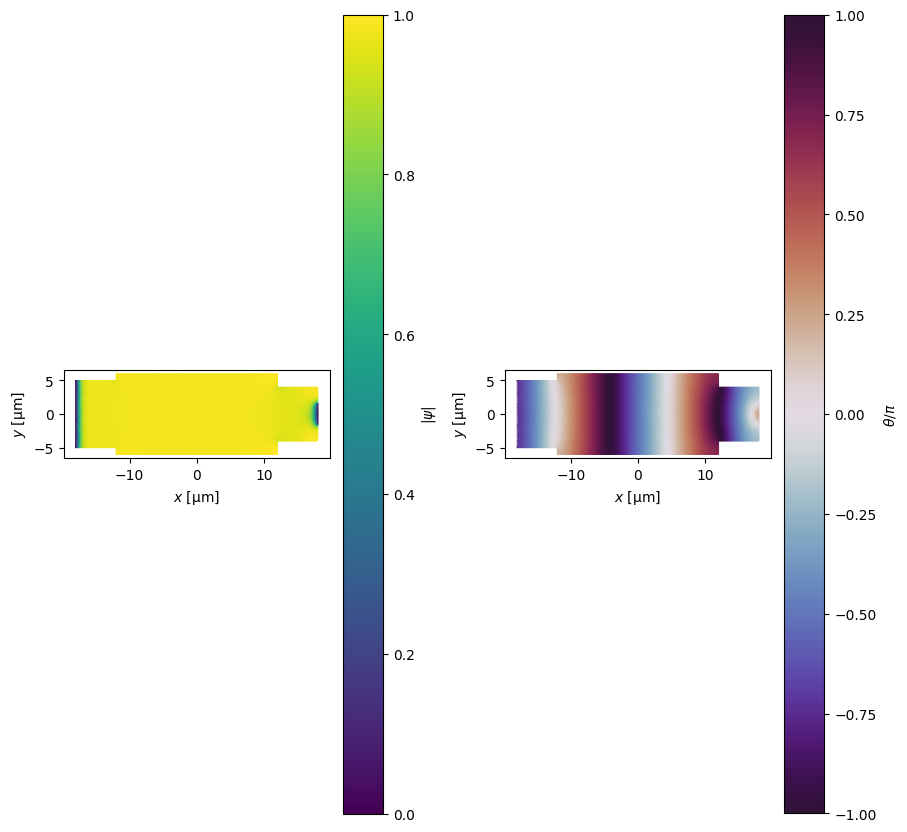

In [15]:
# Create figure with adjusted spacing
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Wider figure (10 inches width)
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots
# Plot the currents
_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Evaluate sheet current density at cross-section
x = np.linspace(-width_x / 2, width_x / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T

plt.tight_layout()  # Automatically adjusts subplots to fit in figure
plt.show()
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 155
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(9, 10))
plt.show()

## 2) Aplicación de campo zero variando la corriente  

In [16]:
def aplicacion_corriente(device,currents,direction):
    voltages = []
    direction = "left_to_right" # Asume una dirección válida aquí, o usa tu lógica de if/else
    if direction == "left_to_right":
        sign1 = 1
        sign2 = -1
    elif direction == "right_to_left":
        sign1 = -1
        sign2 = 1
    else:
        #Si la dirección no es válida, la función debe abortar antes del bucle
        print("please enter a valid direction: left_to_right or right_to_left")
        return None 
    # =========================================================
    # BUCLE DE SIMULACIÓN (CON TEMPORIZADOR Y BARRA DE PROGRESO)
    # =========================================================
    start_time = time.time()
    total_simulations = len(currents)
    j=0
    for I in currents:
        solution = default_solution(
            device_fast,
            f"solution_I_{I:.1f}.h5",
            "0_field",
            terminal_currents_applied=[I * sign1, I * sign2])
        dynamics = solution.dynamics
        indices = dynamics.time_slice(tmin=120)
        voltage = np.abs(np.mean(dynamics.voltage()[indices]))
        voltages.append(voltage)
        j+=1
        print(f"I = {I:.1f} µA, <V> = {voltage:.4f} V₀,progress: {np.round(j/np.size(currents)*100,2)}%", end='\r')
    
  
    clear_output(wait=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(" " * 60, end='\r') 
    print("-" * 50)
    print(f"✅ Simulación completada para {total_simulations} pasos.")
    print(f"⏱️ Tiempo total transcurrido: {elapsed_time:.2f} segundos.")
    print(f"📊 Tiempo promedio por paso: {(elapsed_time / total_simulations):.2f} segundos.")
    print("-" * 50)
    return voltages
def plot_currents(currents,voltages,direction,plot_type="plot",color_applied="teal"):
    plt.figure(figsize=(6, 4))
    if plot_type == "plot":
        plt.plot(currents, voltages, "o-", color=color_applied)
    elif plot_type == "scatter":
        plt.scatter(currents,voltages, "o-", color=color_applied)
    else:
        print("insert a valid plot type")
        return None
    plt.xlabel("Corriente $I$ [$\mu$A]")
    plt.ylabel("Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]")
    plt.title(f'Curva Voltaje vs Corriente (0–15 µA) de {direction}')
    plt.grid(True)
    plt.show()
    plt.savefig("primer_intento.jpg")
Lcurrents = np.arange(-15, 0, 0.5)  # De 20 a 35 µA, paso 0.5
Rcurrents = np.arange(0,15, 0.5) 
total_currents= np.concatenate((Lcurrents,Rcurrents))

<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\D'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alejo\AppData\Local\Temp\ipykernel_25128\1359625487.py:53: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Corriente $I$ [$\mu$A]")
C:\Users\alejo\AppData\Local\Temp\ipykernel_25128\1359625487.py:54: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]")


#### 2.1) Calculo con el dispositivo inicial

In [17]:
voltagesl = aplicacion_corriente(device_fast,Lcurrents,"left_to_right")
voltagesr = aplicacion_corriente(device_fast,Rcurrents,"right_to_left")
voltagesl=np.multiply(voltagesl,-1)
voltagesr = np.multiply(voltagesr,-1)
plot_currents(Lcurrents,voltagesl,"left to right ")
plot_currents(Rcurrents,voltagesr,"right to left")
total_voltages=np.concatenate((actual_voltage_left,voltages2))
plot_currents(total_currents,total_voltages,"complete")


Simulating: 100%|█████████████████████▉| 150/150 [08:36<00:00,  3.45s/tau ]


I = -15.0 µA, <V> = 0.0000 V₀,progress: 3.33%

Simulating: 100%|█████████████████████▉| 150/150 [08:09<00:00,  3.26s/tau ]


I = -14.5 µA, <V> = 0.0000 V₀,progress: 6.67%

Simulating: 100%|██████████████████████| 150/150 [08:19<00:00,  3.33s/tau ]


I = -14.0 µA, <V> = 0.0000 V₀,progress: 10.0%

Simulating: 100%|█████████████████████▉| 150/150 [08:20<00:00,  3.33s/tau ]


I = -13.5 µA, <V> = 0.0000 V₀,progress: 13.33%

Simulating: 100%|█████████████████████▉| 150/150 [08:19<00:00,  3.33s/tau ]


I = -13.0 µA, <V> = 0.0000 V₀,progress: 16.67%

Simulating: 100%|█████████████████████▉| 150/150 [08:31<00:00,  3.41s/tau ]


I = -12.5 µA, <V> = 0.0000 V₀,progress: 20.0%

Simulating: 100%|█████████████████████▉| 150/150 [08:02<00:00,  3.22s/tau ]


I = -12.0 µA, <V> = 0.0000 V₀,progress: 23.33%

Simulating: 100%|██████████████████████| 150/150 [08:10<00:00,  3.27s/tau ]


I = -11.5 µA, <V> = 0.0000 V₀,progress: 26.67%

Simulating: 100%|█████████████████████▉| 150/150 [08:12<00:00,  3.28s/tau ]


I = -11.0 µA, <V> = 0.0000 V₀,progress: 30.0%

Simulating: 100%|██████████████████████| 150/150 [08:01<00:00,  3.21s/tau ]


I = -10.5 µA, <V> = 0.0000 V₀,progress: 33.33%

Simulating: 100%|█████████████████████▉| 150/150 [08:11<00:00,  3.28s/tau ]


I = -10.0 µA, <V> = 0.0000 V₀,progress: 36.67%

Simulating: 100%|█████████████████████▉| 150/150 [08:11<00:00,  3.28s/tau ]


I = -9.5 µA, <V> = 0.0000 V₀,progress: 40.0%

Simulating: 100%|██████████████████████| 150/150 [08:01<00:00,  3.21s/tau ]


I = -9.0 µA, <V> = 0.0000 V₀,progress: 43.33%

Simulating: 100%|█████████████████████▉| 150/150 [08:04<00:00,  3.23s/tau ]


I = -8.5 µA, <V> = 0.0000 V₀,progress: 46.67%

Simulating: 100%|█████████████████████▉| 150/150 [08:04<00:00,  3.23s/tau ]


I = -8.0 µA, <V> = 0.0000 V₀,progress: 50.0%

Simulating: 100%|█████████████████████▉| 150/150 [08:21<00:00,  3.34s/tau ]


I = -7.5 µA, <V> = 0.0000 V₀,progress: 53.33%

Simulating: 100%|█████████████████████▉| 150/150 [07:53<00:00,  3.16s/tau ]


I = -7.0 µA, <V> = 0.0000 V₀,progress: 56.67%

Simulating: 100%|█████████████████████▉| 150/150 [08:12<00:00,  3.28s/tau ]


I = -6.5 µA, <V> = 0.0000 V₀,progress: 60.0%

Simulating: 100%|█████████████████████▉| 150/150 [08:16<00:00,  3.31s/tau ]


I = -6.0 µA, <V> = 0.0000 V₀,progress: 63.33%

Simulating: 100%|█████████████████████▉| 150/150 [07:46<00:00,  3.11s/tau ]


I = -5.5 µA, <V> = 0.0000 V₀,progress: 66.67%

Simulating: 100%|██████████████████████| 150/150 [08:20<00:00,  3.34s/tau ]


I = -5.0 µA, <V> = 0.0000 V₀,progress: 70.0%

Simulating: 100%|█████████████████████▉| 150/150 [09:00<00:00,  3.60s/tau ]


I = -4.5 µA, <V> = 0.0000 V₀,progress: 73.33%

Thermalizing:  33%|██████▊              | 33/100 [03:13<04:32,  4.06s/tau ]

Simulation paused at stage 'Thermalizing' (step 21536). Continue simulation? [yN] N


Cancelling simulation at step 21536 of stage 'Thermalizing'.
Thermalizing:  33%|██████▉              | 33/100 [03:18<06:48,  6.07s/tau ]
C:\Users\alejo\AppData\Local\Temp\ipykernel_25128\1359625487.py:53: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Corriente $I$ [$\mu$A]")
C:\Users\alejo\AppData\Local\Temp\ipykernel_25128\1359625487.py:54: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Voltaje promedio $\\langle \Delta \\mu \\rangle$ [$V_0$]")


AttributeError: 'NoneType' object has no attribute 'dynamics'

### 2.2)Campo zero con variación de corriente para modificacionesen la parte derecha del device

In [ ]:
#de 9 a 3 
size = 7
voltages_arri = np.empty(size)
voltages_arrd = np.empty(size)
voltages_totalArr = np.empty(size)
for i in range(3,10):
    deltay = height_y2 - i
    device_fast_2  = create_device(half_geometry,MAX_EDGE_LENGTH_IV,polyx=width_x2,polyy=deltay,drain_dimensions=[STRIPE_LENGTH,(deltay)])
    fig, ax = device_fast_2.draw()
    voltages_i = aplicacion_corriente(device_fast_2,Lcurrents,"left_to_right")
    voltages_d = aplicacion_corriente(device_fast_2,Rcurrents,direction2,"right_to_left")
    voltages_i =  np.multiply(voltages2i,-1)
    voltages_d = np.multiply(voltages2d,-1)
    voltages_arri[i] = voltages_i
    voltages_arrd[i] = voltages_d 
    total_voltages=np.concatenate((voltages_2i,voltages_2d))
    voltages_totalArr[i] = total_voltages
    plot_currents(total_currents,total_voltages_2,"complete")

   

## 3)Solo campo aplicado 

In [ ]:
from tdgl.sources import ConstantField
# =========================
# 2) Parámetros del material
# =========================
d = 0.1  # Grosor del superconductor en micrómetros (µm)
area_fast = np.sum(device_fast.areas)  # Área efectiva del dispositivo (en µm²)
# =========================
# 3) Barrido en B externo
# =========================
# Define una lista de 100 valores de campo magnético externo entre 0 y 1 mT
campos_fast = np.linspace(0.0, 2, 100)  # Campo B externo en mT
momentos_fast = []  # Lista para almacenar el momento magnético total
magnetizaciones_fast = []  # Lista para almacenar la magnetización volumétrica
# Bucle para cada valor de campo magnético externo
for B in campos_fast:
    # Crea un campo magnético uniforme de magnitud B
    campo_ext = ConstantField(B, field_units=options.field_units, length_units=device_fast.length_units)
    # Resuelve las ecuaciones de Ginzburg–Landau con el campo aplicado
    solucion = default_solution(device_fast,"Bscan.h5"," ",vector_potential=campo_ext,terminal_currents_applied=[0.0,0.0])
    # Calcula el momento magnético total (uA · µm²) — función clave del análisis
    m = solucion.magnetic_moment(units="uA * um**2", with_units=False)
    momentos_fast.append(m)  # Almacena el valor
    # Calcula la magnetización volumétrica: M = m / (Área × grosor)  en µA / µm³
    M = m / (area_fast * d)
    magnetizaciones_fast.append(M)

# =========================
# 4) Calcular susceptibilidad dM/dB
# =========================
# Convierte la lista a array de NumPy
magnetizaciones_fast = np.array(magnetizaciones_fast)
# Derivada numérica de la magnetización respecto al campo: dM/dB
# Esto da la susceptibilidad magnética en unidades de µA / (µm³ · mT)
#suceptibilidad_rr = np.gradient(magnetizaciones_rr, campos_rr)
# =========================
# 5) Guardar datos en archivos
# =========================
# Guarda magnetización en archivo de texto
np.savetxt("magnetizacion_rr_vs_B.txt", np.column_stack((campos_fast, magnetizaciones_fast)),
           header="B[mT] M[uA/um^3]")
# Guarda susceptibilidad en archivo de texto
#np.savetxt("suceptibilidad_rr_vs_B.txt", np.column_stack((campos_rr, suceptibilidad_rr)),
           #header="B[mT] dM/dB [uA/(um^3·mT)]")
# Crea la figura de M(B)
plt.figure(figsize=(7, 5))
plt.plot(campos_fast, -magnetizaciones_fast, 's-', color='crimson', label='Puente_ancho', linewidth=1.5, markersize=3)